In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits import mplot3d

# 1)

To look at whether or not the points generated by the standard C library are truly randomly distributed, we look at them grouped in triples $(x,y,z)$. We can plot these values where each triple is represented by a point in 3D space. Were these numbers truly random, we should be able to see these points filling up the volume.

In [3]:
rand_triples = np.loadtxt('rand_points.txt')

<IPython.core.display.Javascript object>


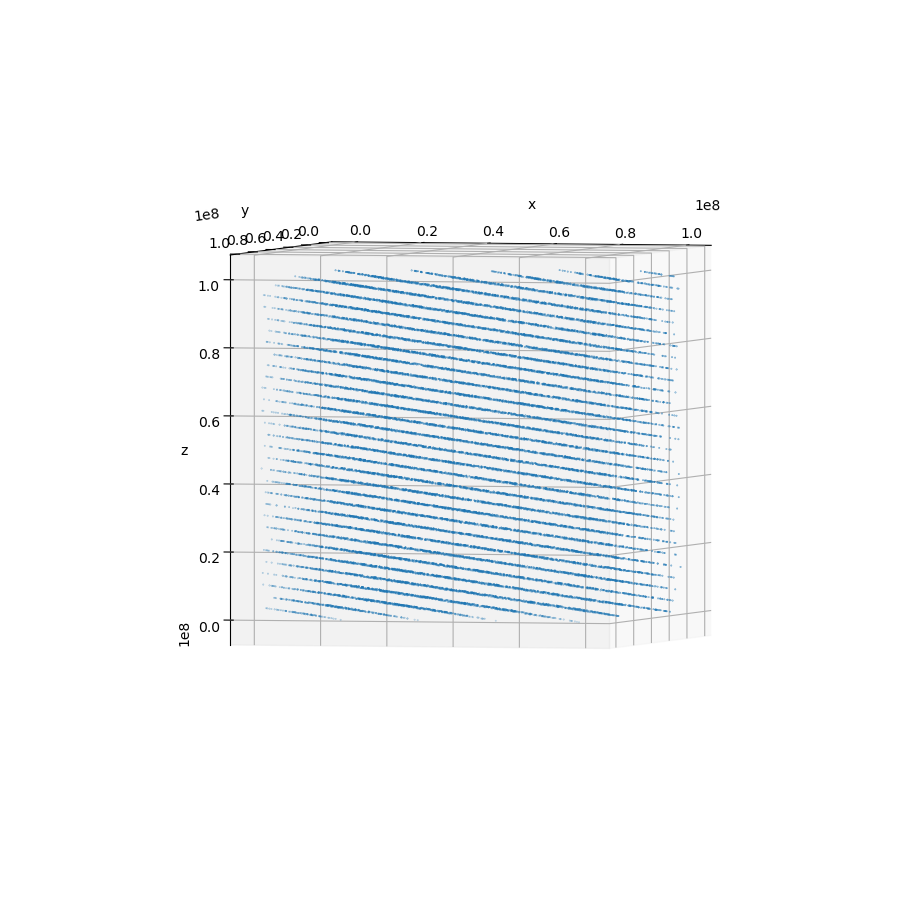

In [4]:
fig = plt.figure(figsize = (9,9))
ax = plt.axes(projection='3d', proj_type = 'ortho')
ax.scatter(rand_triples[:,0],rand_triples[:,1],rand_triples[:,2],s = 0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-2., azim=-105)

As we can see, the triples of random numbers lay on discrete planes in 3D space. Hence, there is a correlation between subsequent generated numbers, i.e., they are not truly random. Alternatively, we can look at a plot of $z = ax+by$. By trial and error, we can get a and b values such that we see the projection of the planes from the above plot.

<IPython.core.display.Javascript object>


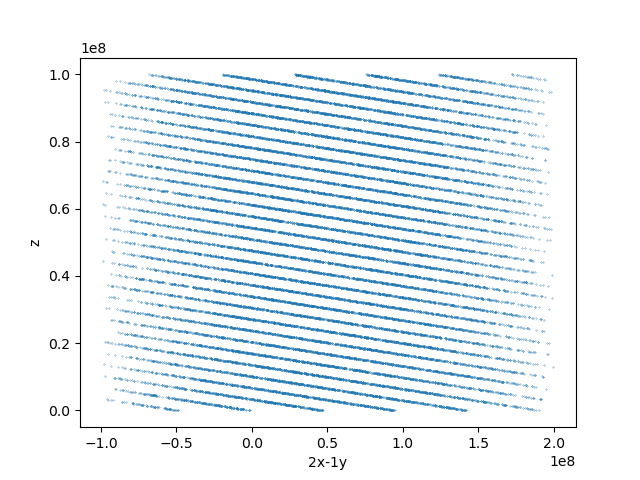

Text(0, 0.5, 'z')

In [5]:
a=2
b=-1

plt.figure()
plt.plot(a*rand_triples[:,0]+b*rand_triples[:,1],rand_triples[:,2],'.',markersize = 0.5)
plt.xlabel('{}x-{}y'.format(a,-b))
plt.ylabel('z')

Now, let us see if this effect is present using numpy's uniform random number generator. We will generate as many random numbers as the C library example, and organise them in triples. 

In [15]:
pyt_rand_triples = np.random.uniform(0,1e8,(len(rand_triples)*3))
pyt_rand_triples = pyt_rand_triples.reshape((len(rand_triples),3))

<IPython.core.display.Javascript object>


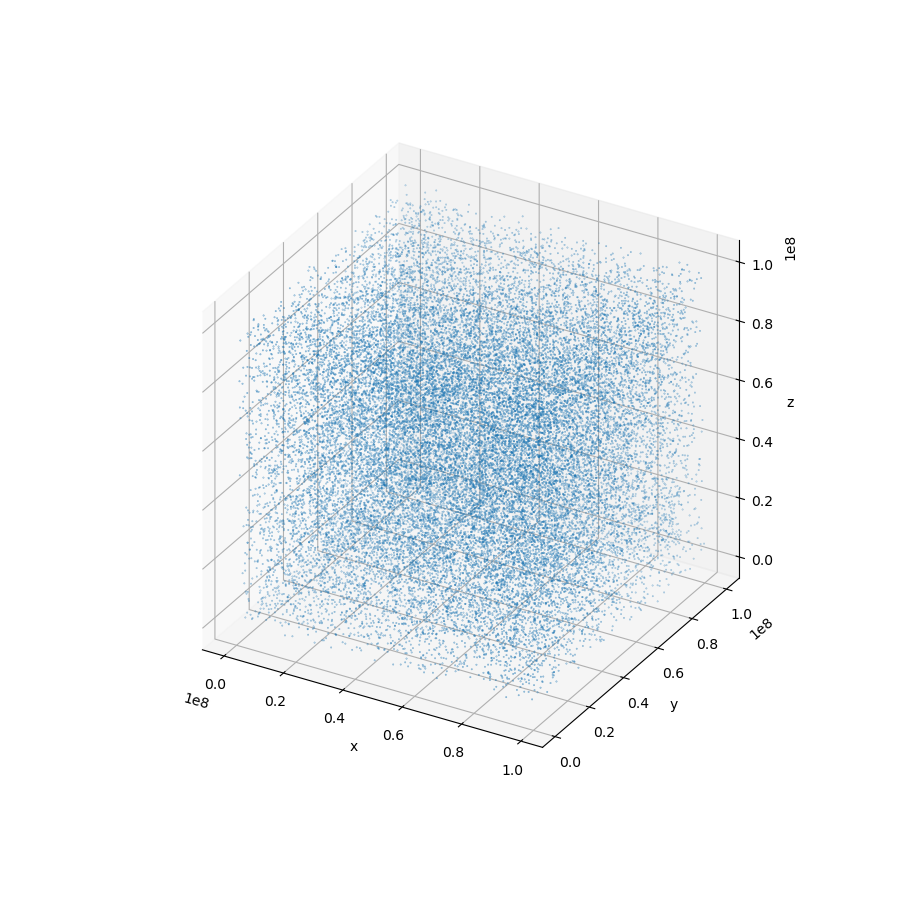

Text(0.5, 0, 'z')

In [17]:
fig = plt.figure(figsize = (9,9))
ax = plt.axes(projection='3d', proj_type = 'ortho')
ax.scatter(pyt_rand_triples[:,0],pyt_rand_triples[:,1],pyt_rand_triples[:,2],s = 0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


By moving the view of the plot, we cannot find an angle for which we see the points form structure. It was fairly easy to do so for the C random number generator, but even by trying for a while, we do not see this effect here.

# 2)

To generate exponential deviates using a rejection method, we need to use a distribution which bounds the exponential one for all $x$. We cannot use a Gaussian distribution because a Gaussian of the form $Ae^{-x^2/\sigma^2}$ will always ends up decreasing faster than $e^{-x}$ for some large x, whatever the other parameters of the Gaussian.

For a lorentzian distribution, this is not a problem, because the exponential will always decay faster. Hence, if we can draw random samples from a lorentzian distribution, we can use a rejection method to only keep samples that belong in the exponential distribution. Here, we will only generate deviates $0<x<\infty$.

<IPython.core.display.Javascript object>


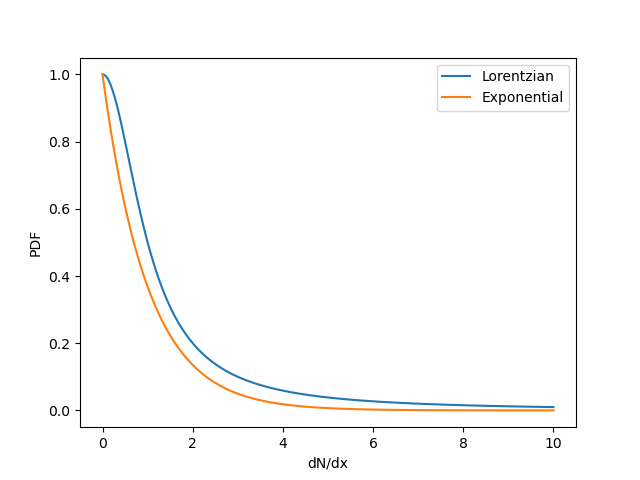

In [31]:
def lorentzian(x):
    return (1+x**2)**-1

xmax = 10
x = np.linspace(0,xmax,1001)
plt.figure()
plt.plot(x,lorentzian(x),label = 'Lorentzian')
plt.plot(x,np.exp(-x),label = 'Exponential')
plt.xlabel('dN/dx')
plt.ylabel('PDF')
plt.legend()

To generate random samples from a lorentzian distrubution, we can use uniformally random numbers $0<r<1$ and plug those in the reciprocal of the CDF to have lorentzian distributed numbers. We need to normalize the PDF first.

$$\int_0^\infty \frac{1}{1+x^2}dx = arctan(x)|^\infty_0 = \pi/2$$

So the normalized PDF is $2/\pi\frac{1}{1+x^2}$, and its CDF is

$$\int_0^x 2/\pi\frac{1}{1+x'^2}dx' = \frac{2}{\pi} arctan(x)$$

Now, this CDF is $0$ at $x=0$ and $1$ for $x\to\infty$. So setting this equal to $0<r<1$ and solving for $x$ yields

$$ x = tan(\frac{\pi}{2}r)$$

if we use a selection of uniformally distributed numbers $r_i$ between $0$ and $1$, we get lorentzian distributed $x_i$

Now, to have our exponentially distributed numbers, we need to reject the samples wich are not part of the exponential distribution. To do so, we generate new random numbers $0<u<1$, and accept only the random lorentzian random numbers which satisfy $u<\frac{e^{-x_i}}{1/(1+x_i^2)}$. To verify that everything works correctly, we expect to accept numbers with a rate that is equal to the ratio of the areas of the distributions, i.e.

$$acceptance\ rate = \frac{\int_0^\infty e^{-x}dx}{\int_0^\infty \frac{1}{1+x^2}dx} = 2/\pi$$

In [19]:
def rand_exp(N):
    def lor_cdf_inv(r):
        return np.tan(np.pi/2*r)
    rs = np.random.rand(N)
    lor_rand = lor_cdf_inv(rs)
    acc = np.random.rand(N)<np.exp(-lor_rand)/lorentzian(lor_rand)
    print('Accepted ',np.mean(acc)*100,'% of samples')
    return lor_rand[acc]

In [24]:
xmax = 10
a = rand_exp(1000000)
print('Theoretical acceptance rate: ',2/np.pi*100,'%')

Accepted  63.7151 % of samples
Theoretical acceptance rate:  63.66197723675814 %


Now, we plot our distribution by taking datapoints corresponding to the bins of the histograms:

<IPython.core.display.Javascript object>


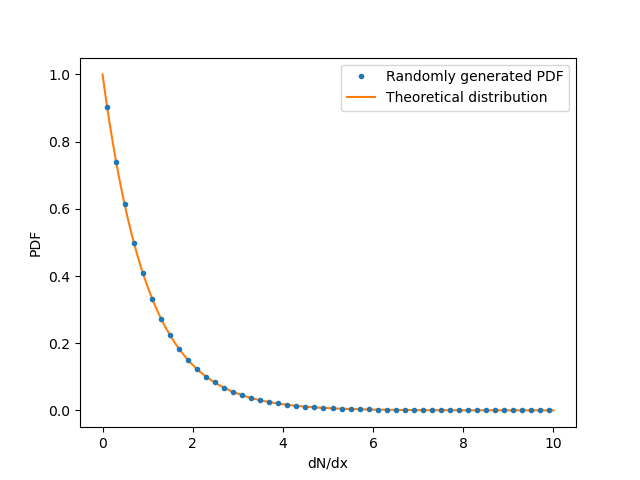

In [33]:
plt.figure()
ybins,bins= np.histogram(a,np.linspace(0,10,51),density = True)
binw = bins[1]-bins[0]
bins+=binw/2
plt.plot(bins[:-1],ybins,'.',label ='Randomly generated PDF')
ytrue = np.exp(-x)
plt.plot(x,ytrue,zorder = 0,label = 'Theoretical distribution')
plt.xlabel('dN/dx')
plt.ylabel('PDF')
plt.legend()

Our numbers are indeed exponentially distributed.

# 3)